In [16]:
import torch.nn as nn
import sys
import os
import h5py
import time
import torch
import gc
import configparser
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt
from numpy.random import default_rng
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "model")))
from model import unet, dataflow


In [17]:
data_h5_filepath = '../data/mt_rainier_eq_car_data.h5'
data_list = []

# Load the data
with h5py.File(data_h5_filepath, 'r', locking=False) as f:
    for key in f.keys():
        data = f[key][()]  # Load the dataset as a NumPy array
        data_list.append(data)

data_array = np.stack(data_list)
print(f"Data shape: {data_array.shape}")

Data shape: (900, 1500, 1500)


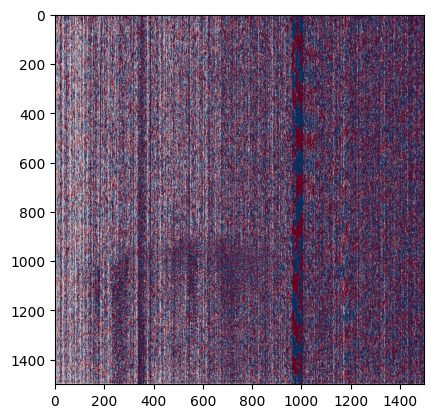

In [18]:
plt.imshow(data_array[1, :, :], cmap="RdBu", vmin=-0.1, vmax=0.1)

In [19]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): trace print function.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [20]:
def train_augmentation(train_dataloader, validate_dataloader, model, loss_fn, optimizer, lr_schedule, epochs,
                        patience, device, minimum_epochs=None):
    # get early_stopping ready
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # save history of losses every epoch
    avg_train_losses = []
    avg_valid_losses = []

    for epoch in range(1, epochs + 1):
        starttime = time.time()  # record time for each epoch
        train_losses = []  # save loss for every batch
        valid_losses = []

        # ======================= training =======================
        model.train()  # train mode on
        for batch, ((X, mask), y) in enumerate(train_dataloader):
            X, mask, y = X.to(device), mask.to(device), y.to(device)

            # predict and loss
            pred = model(X * mask)
            loss = loss_fn(pred * (1-mask), y)
            train_losses.append(loss.item())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ======================= validating =======================
        model.eval()  # evaluation model on
        with torch.no_grad():
            for (X, mask), y in validate_dataloader:
                X, mask, y = X.to(device), mask.to(device), y.to(device)

                pred = model(X * mask)
                loss = loss_fn(pred * (1-mask), y)
                valid_losses.append(loss.item())

        # average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        lr_schedule.step(valid_loss)

        # ==================== history monitoring ====================
        # print training/validation statistics
        epoch_len = len(str(epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'time per epoch: {(time.time() - starttime):.3f} s')
        print(print_msg)

        if (minimum_epochs is None) or ((minimum_epochs is not None) and (epoch > minimum_epochs)):
            # if the current valid loss is lowest, save a checkpoint of model weights
            early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # load the last checkpoint as the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses

In [21]:
def try_gpu(i=0):
    if torch.cuda.device_count() > i:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [22]:
def train(data): # data is a numpy array
    
    """ Prepare the data for training """
    # x = data.T[np.newaxis, :, :]
    # x = np.repeat(x, 5, axis=0)
    # x = data.transpose(0, 2, 1)[:, np.newaxis, :, :]  # shape (N, 1, X, T)
    # training_data = dataflow(x[:4])
    # validation_data = dataflow(x[4:])
    x = data
    # x = data[0:3, :, :]
    print(x.shape)
    num_samples = x.shape[0]
    split_idx = int(num_samples * 0.8)
    print(x[:split_idx].shape, x[split_idx:].shape)
    training_data = dataflow(x[:split_idx])
    validation_data = dataflow(x[split_idx:])


    """ Initialize the U-net model """
    model = unet(1, 16, 1024, factors=(5, 3, 2, 2))
    devc = try_gpu()
    model.to(devc)
    # %% Hyper-parameters for training
    batch_size = 10
    lr = 1e-3
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    train_iter = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    validate_iter = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',        # reduce LR when the monitored quantity has stopped decreasing
        factor=0.5,        # reduce by half
        patience=3,        # wait 3 epochs before reducing
        verbose=True
    )

    model, avg_train_losses, avg_valid_losses = train_augmentation(train_iter,
                                                                   validate_iter,
                                                                   model,
                                                                   loss_fn,
                                                                   optimizer,
                                                                   lr_scheduler,
                                                                   epochs=50,
                                                                   patience=6,
                                                                   device=devc,
                                                                   minimum_epochs=5)
    
    return model, avg_train_losses, avg_valid_losses

In [23]:
# gc.collect()
# model, avg_train_losses, avg_valid_losses = train(data_array)

# Train the model with the correct data format

gc.collect()

# Fix the data format issue by reshaping the data
# The dataflow class expects data in shape (N, X, T) not (N, C, X, T)
fixed_data = data_array  # Use original data shape (N, X, T)

print(f"Input data shape: {fixed_data.shape}")

# Call the train function with correctly shaped data
model, avg_train_losses, avg_valid_losses = train(fixed_data)

Input data shape: (900, 1500, 1500)
(900, 1500, 1500)
(720, 1500, 1500) (180, 1500, 1500)
7200 1500 1500


1800 1500 1500


/home/ajm76/miniconda3/envs/FM_DAS/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.68 GiB. GPU 0 has a total capacity of 23.68 GiB of which 1.09 GiB is free. Process 982184 has 276.00 MiB memory in use. Process 2397443 has 360.00 MiB memory in use. Process 3060574 has 528.00 MiB memory in use. Process 3075977 has 256.00 MiB memory in use. Process 165984 has 512.00 MiB memory in use. Process 907886 has 432.00 MiB memory in use. Process 1103141 has 276.00 MiB memory in use. Process 1377764 has 276.00 MiB memory in use. Process 2119647 has 276.00 MiB memory in use. Process 2119931 has 276.00 MiB memory in use. Process 3708493 has 276.00 MiB memory in use. Including non-PyTorch memory, this process has 18.90 GiB memory in use. Of the allocated memory 12.90 GiB is allocated by PyTorch, and 5.70 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

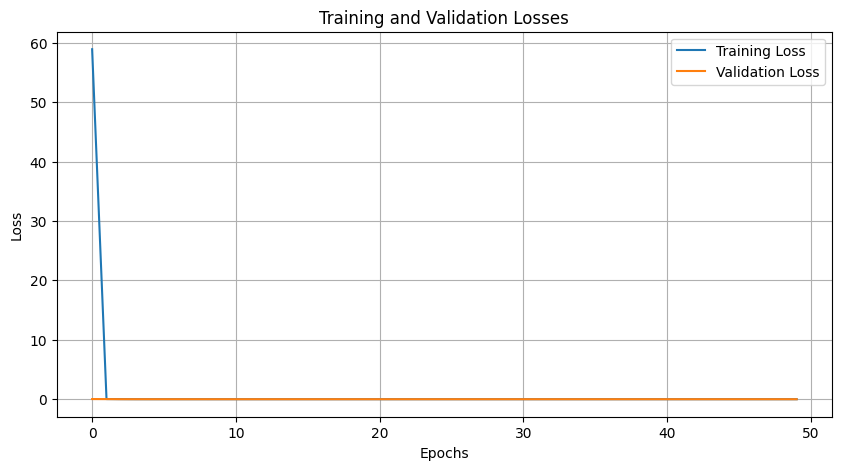

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()